# Models for Anomaly Detection
### 1. One-class SVM
### 2. Isolation Forest
### 3. Local Outlier Factor
### 4. AutoEncoder

### Training on Local Machine

In [8]:
import os

original_working_directory_path = os.getcwd()
print("The original working directory is {0}".format(os.getcwd()))

def to_original_working_directory():
    os.chdir(original_working_directory_path)
    print(f"Changed to original working directory {original_working_directory_path}")

The original working directory is /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_02


In [9]:
def to_root_working_directory():
    root_working_directory_path = os.path.join(original_working_directory_path, "../..")
    os.chdir(root_working_directory_path)
    print(f"Changed to root working directory {os.getcwd()}")

In [10]:
to_root_working_directory()

Changed to root working directory /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


### Functions

In [144]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate(model, data_dict, tablefmt='latex_raw'):
        results = []
        labels= [-1,1]
        pos_label = 1
        
        y_true_total = np.empty([0])
        y_pred_total = np.empty([0])
        for behavior, data in data_dict.items():
            y_true = data[:,-1].astype(int)
            y_true_total = np.concatenate((y_true_total, y_true))

            y_pred = model.predict(data[:, :-1].astype(np.float32))
            y_pred_total = np.concatenate((y_pred_total, y_pred))

            accuracy = accuracy_score(y_true, y_pred)

            n_samples = len(y_true)
            results.append([behavior.name.replace("_", "\_"), f'{(100 * accuracy):.2f}\%', '\\notCalculated', '\\notCalculated', '\\notCalculated', str(n_samples)])

        accuracy = accuracy_score(y_true_total, y_pred_total)
        precision = precision_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        recall = recall_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        f1 = f1_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        n_samples = len(y_true_total)
        results.append(["GLOBAL", f'{(100 * accuracy):.2f}\%', f'{(100 * precision):.2f}\%', f'{(100 * recall):.2f}\%', f'{(100 * f1):.2f}\%', n_samples])
        print(tabulate(results, headers=["Behavior", "Accuracy", "Precision", "Recall", "F1-Score", "\\#Samples"], tablefmt=tablefmt)) 

In [196]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [71]:
import pandas as pd

def convert_grid_search_result(grid_search_result, display_latex=True):
    df = pd.concat([pd.DataFrame(grid_search_result.cv_results_["mean_test_score"], columns=["mean_validation_accuracy"]), pd.DataFrame(grid_search_result.cv_results_["params"])],axis=1).sort_values(by=['mean_validation_accuracy'], ascending=False)
    df.index = np.arange(1, len(df) + 1)
    return df

In [163]:
import pandas as pd

def display_grid_search_result(df, n_items=10):
    print(df.head(n_items).to_latex(escape=True, bold_rows=True))

### Data Preparation

In [56]:
from src.data_provider import DataProvider

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(pi=3, scaling_minmax=True, scale_normal_only=True)

In [22]:
import numpy as np

def get_training_datasets(training_data_dict, normal_label, abnormal_label):
    training_data_50 = np.empty([0,47])
    training_data_80 = np.empty([0,47])
    for behavior, behavior_data in training_data_dict.items():

        if behavior == Behavior.NORMAL:
            behavior_data[:, -1] =  normal_label # SVM uses 1 for normal
            training_data_50 = np.concatenate([training_data_50, behavior_data[:7000,:]], axis=0)
            training_data_80 = np.concatenate([training_data_80, behavior_data[:8000,:]], axis=0)
        else:
            behavior_data[:, -1] =  abnormal_label # SVM uses -1 for outlier
            training_data_50 = np.concatenate([training_data_50, behavior_data[:1000,:]], axis=0)
            training_data_80 = np.concatenate([training_data_80, behavior_data[:286,:]], axis=0)

    return training_data_50, training_data_80

In [28]:
import numpy as np

def get_test_datasets(test_data, normal_label, abnormal_label):
    test_data_dict = {}
    test_data_flat = np.zeros([0, 47])

    for behavior, behavior_data in test_data.items():
        if behavior == Behavior.NORMAL:
            behavior_data = behavior_data[:2800]
            behavior_data[:, -1] =  1
        else:
            behavior_data = behavior_data[:400]
            behavior_data[:, -1] =  -1

        test_data_dict[behavior] = behavior_data
        test_data_flat = np.vstack([test_data_flat, behavior_data])

    return test_data_dict, test_data_flat

## 1. One-class SVM

In [124]:
svm_training_data_50, svm_training_data_80 = get_training_datasets(train_data, 1, -1)

svm_training_x_50  = svm_training_data_50[:,:-1]
svm_training_y_50  = svm_training_data_50[:,-1].astype(int)

svm_training_x_80 = svm_training_data_80[:,:-1]
svm_training_y_80 = svm_training_data_80[:,-1].astype(int)

In [125]:
svm_test_data_dict, svm_test_data_flat = get_test_datasets(test_data, 1, -1)

In [142]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV

svm_grid_search_50 = GridSearchCV(estimator=OneClassSVM(nu=0.5, verbose=False), 
                           param_grid=param_grid,
                           scoring='accuracy',
                           n_jobs=1,
                           cv=5,
                           verbose=3,
                           refit=True)

#Fitting 5 folds for each of 26 candidates, totalling 130 fits
svm_grid_search_result_50 = svm_grid_search_50.fit(svm_training_x_50, svm_training_y_50)

Fitting 5 folds for each of 26 candidates, totalling 130 fits
[CV 1/5] END .....kernel=linear, shrinking=True;, score=0.297 total time=   5.4s
[CV 2/5] END .....kernel=linear, shrinking=True;, score=0.280 total time=   5.2s
[CV 3/5] END .....kernel=linear, shrinking=True;, score=0.177 total time=   5.3s
[CV 4/5] END .....kernel=linear, shrinking=True;, score=0.511 total time=   5.0s
[CV 5/5] END .....kernel=linear, shrinking=True;, score=0.325 total time=   5.2s
[CV 1/5] END ....kernel=linear, shrinking=False;, score=0.297 total time=   5.1s
[CV 2/5] END ....kernel=linear, shrinking=False;, score=0.280 total time=   5.6s
[CV 3/5] END ....kernel=linear, shrinking=False;, score=0.177 total time=   4.9s
[CV 4/5] END ....kernel=linear, shrinking=False;, score=0.511 total time=   4.6s
[CV 5/5] END ....kernel=linear, shrinking=False;, score=0.325 total time=   4.7s
[CV 1/5] END gamma=scale, kernel=rbf, shrinking=True;, score=0.639 total time=   9.9s
[CV 2/5] END gamma=scale, kernel=rbf, shri

In [145]:
# Display the best hyperparameter configuration for the 50:50 dataset
svm_grid_search_result_table_50 = convert_grid_search_result(svm_grid_search_result_50)
display_grid_search_result(svm_grid_search_result_table_50)

\begin{tabular}{lrlllr}
\toprule
{} &  mean\_validation\_accuracy & kernel &  shrinking &  gamma &  degree \\
\midrule
\textbf{1 } &                  0.698786 &    rbf &       True &   auto &     NaN \\
\textbf{2 } &                  0.698786 &    rbf &      False &   auto &     NaN \\
\textbf{3 } &                  0.626143 &    rbf &       True &  scale &     NaN \\
\textbf{4 } &                  0.626143 &    rbf &      False &  scale &     NaN \\
\textbf{5 } &                  0.332071 &   poly &      False &  scale &     5.0 \\
\textbf{6 } &                  0.332071 &   poly &       True &  scale &     5.0 \\
\textbf{7 } &                  0.331357 &   poly &       True &  scale &     4.0 \\
\textbf{8 } &                  0.331357 &   poly &      False &  scale &     4.0 \\
\textbf{9 } &                  0.328500 &   poly &       True &  scale &     3.0 \\
\textbf{10} &                  0.328500 &   poly &      False &  scale &     3.0 \\
\bottomrule
\end{tabular}



In [147]:
# Testing the best hyperparameter configuration on the 50:50 dataset
best_svm_50 = OneClassSVM(nu=0.50, kernel = 'rbf', gamma = 'auto')
best_svm_50.fit(svm_training_x_50)
evaluate(best_svm_50, svm_test_data_dict, 'latex_raw')

\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 55.75\%    & \notCalculated & \notCalculated & \notCalculated &        2800 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BDVL            & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BEURK           & 50.75\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_THETICK             & 53.75\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_BACKDOOR\_JAKORITAR & 49.50\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT1                & 52.75\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\

In [128]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV

svm_grid_search_80 = GridSearchCV(estimator=OneClassSVM(nu=0.2, verbose=False), 
                           param_grid=param_grid,
                           scoring='accuracy',
                           n_jobs=1,
                           return_train_score=True,
                           cv=5,
                           verbose=3,
                           refit=True)

# Fitting 5 folds for each of 26 candidates, totalling 130 fits
svm_grid_search_result_80 = svm_grid_search_80.fit(svm_training_x_80, svm_training_y_80)

Fitting 5 folds for each of 26 candidates, totalling 130 fits
[CV 1/5] END kernel=linear, shrinking=True;, score=(train=0.606, test=0.787) total time=   1.0s
[CV 2/5] END kernel=linear, shrinking=True;, score=(train=0.602, test=0.766) total time=   1.0s
[CV 3/5] END kernel=linear, shrinking=True;, score=(train=0.602, test=0.766) total time=   1.0s
[CV 4/5] END kernel=linear, shrinking=True;, score=(train=0.603, test=0.746) total time=   1.0s
[CV 5/5] END kernel=linear, shrinking=True;, score=(train=0.800, test=0.099) total time=   1.0s
[CV 1/5] END kernel=linear, shrinking=False;, score=(train=0.606, test=0.787) total time=   0.9s
[CV 2/5] END kernel=linear, shrinking=False;, score=(train=0.602, test=0.766) total time=   0.9s
[CV 3/5] END kernel=linear, shrinking=False;, score=(train=0.602, test=0.766) total time=   0.9s
[CV 4/5] END kernel=linear, shrinking=False;, score=(train=0.603, test=0.746) total time=   0.9s
[CV 5/5] END kernel=linear, shrinking=False;, score=(train=0.800, test

In [148]:
# Display the best hyperparameter configuration for the 80:20 dataset
svm_grid_search_result_table_80 = convert_grid_search_result(svm_grid_search_result_80)
display_grid_search_result(svm_grid_search_result_table_80)

\begin{tabular}{lrlllr}
\toprule
{} &  mean\_validation\_accuracy &   kernel &  shrinking &  gamma &  degree \\
\midrule
\textbf{1 } &                  0.836218 &      rbf &       True &   auto &     NaN \\
\textbf{2 } &                  0.836218 &      rbf &      False &   auto &     NaN \\
\textbf{3 } &                  0.805023 &      rbf &       True &  scale &     NaN \\
\textbf{4 } &                  0.804823 &      rbf &      False &  scale &     NaN \\
\textbf{5 } &                  0.633645 &  sigmoid &       True &  scale &     NaN \\
\textbf{6 } &                  0.633645 &  sigmoid &      False &  scale &     NaN \\
\textbf{7 } &                  0.632845 &   linear &       True &    NaN &     NaN \\
\textbf{8 } &                  0.632845 &  sigmoid &       True &   auto &     NaN \\
\textbf{9 } &                  0.632845 &  sigmoid &      False &   auto &     NaN \\
\textbf{10} &                  0.632845 &   linear &      False &    NaN &     NaN \\
\bottomrule
\end{ta

In [150]:
# Testing the best hyperparameter configuration on the 80:20 dataset
best_svm_80 = OneClassSVM(nu=0.20, kernel = 'rbf', gamma = 'auto')
best_svm_80.fit(svm_training_x_80)
evaluate(best_svm_80, svm_test_data_dict)

\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 76.18\%    & \notCalculated & \notCalculated & \notCalculated &        2800 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BDVL            & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BEURK           & 25.50\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_THETICK             & 27.00\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_BACKDOOR\_JAKORITAR & 24.00\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT1                & 37.25\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\

## 2. Isolation Forest

In [177]:
isf_training_data_50, isf_training_data_80 = get_training_datasets(train_data, 1, -1)

isf_training_x_50 = isf_training_data_50[:,:-1]
isf_training_y_50 = isf_training_data_50[:,-1].astype(int)

isf_training_x_80 = isf_training_data_80[:,:-1]
isf_training_y_80 = isf_training_data_80[:,-1].astype(int)

In [178]:
isf_test_data_dict, isf_test_data_flat = get_test_datasets(test_data, 1, -1)

In [179]:
param_grid = {
    'n_estimators': list(range(10,101,10)), 
    'max_samples': ["auto"], 
    'max_features': np.linspace(0.1, 1.0, 10), 
}

In [180]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

isolation_forest_50 = IsolationForest(contamination=0.5, random_state=42)

isf_grid_search_50 = GridSearchCV(isolation_forest_50, 
                                                 param_grid,
                                                 scoring='accuracy', 
                                                 refit=False,
                                                 cv=5, 
                                                 return_train_score=True,
                                                 verbose=3,
                                                 n_jobs=1)

#Fitting 5 folds for each of 100 candidates, totalling 500 fits
isf_grid_search_result_50 = isf_grid_search_50.fit(isf_training_x_50, isf_training_y_50)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END max_features=0.1, max_samples=auto, n_estimators=10;, score=(train=0.618, test=0.636) total time=   0.1s
[CV 2/5] END max_features=0.1, max_samples=auto, n_estimators=10;, score=(train=0.619, test=0.675) total time=   0.1s
[CV 3/5] END max_features=0.1, max_samples=auto, n_estimators=10;, score=(train=0.608, test=0.779) total time=   0.1s
[CV 4/5] END max_features=0.1, max_samples=auto, n_estimators=10;, score=(train=0.693, test=0.492) total time=   0.1s
[CV 5/5] END max_features=0.1, max_samples=auto, n_estimators=10;, score=(train=0.626, test=0.787) total time=   0.1s
[CV 1/5] END max_features=0.1, max_samples=auto, n_estimators=20;, score=(train=0.636, test=0.682) total time=   0.1s
[CV 2/5] END max_features=0.1, max_samples=auto, n_estimators=20;, score=(train=0.621, test=0.663) total time=   0.1s
[CV 3/5] END max_features=0.1, max_samples=auto, n_estimators=20;, score=(train=0.617, test=0.791) total time= 

In [181]:
# Display the best hyperparameter configuration for the 50:50 dataset
isf_grid_search_result_table_50 = convert_grid_search_result(isf_grid_search_result_50)
display_grid_search_result(isf_grid_search_result_table_50)

\begin{tabular}{lrrlr}
\toprule
{} &  mean\_validation\_accuracy &  max\_features & max\_samples &  n\_estimators \\
\midrule
\textbf{1 } &                  0.722143 &           0.7 &        auto &            50 \\
\textbf{2 } &                  0.721357 &           0.7 &        auto &            70 \\
\textbf{3 } &                  0.720000 &           0.7 &        auto &            60 \\
\textbf{4 } &                  0.715286 &           0.7 &        auto &           100 \\
\textbf{5 } &                  0.715000 &           0.7 &        auto &            30 \\
\textbf{6 } &                  0.713786 &           0.7 &        auto &            10 \\
\textbf{7 } &                  0.713500 &           0.7 &        auto &            80 \\
\textbf{8 } &                  0.711143 &           0.7 &        auto &            90 \\
\textbf{9 } &                  0.709571 &           1.0 &        auto &            30 \\
\textbf{10} &                  0.709214 &           0.6 &        auto &  

In [182]:
isolation_forest_50 = IsolationForest(contamination=0.5, random_state=42, max_features=0.7, max_samples='auto', n_estimators=60)
isolation_forest_50.fit(isf_training_x_50, isf_training_y_50);
evaluate(isolation_forest_50, isf_test_data_dict)

\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 56.82\%    & \notCalculated & \notCalculated & \notCalculated &        2800 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BDVL            & 90.50\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BEURK           & 50.00\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_THETICK             & 60.00\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_BACKDOOR\_JAKORITAR & 46.50\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT1                & 60.50\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\

In [183]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

isolation_forest_80 = IsolationForest(contamination=0.2, random_state=42)

isf_grid_search_80 = GridSearchCV(isolation_forest_80, 
                                                 param_grid,
                                                 scoring='accuracy', 
                                                 refit=False,
                                                 cv=5, 
                                                 return_train_score=True,
                                                 verbose=3,
                                                 n_jobs=1)

#Fitting 5 folds for each of 100 candidates, totalling 500 fits
isf_grid_search_result_80 = isf_grid_search_80.fit(isf_training_x_80, isf_training_y_80)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END max_features=0.1, max_samples=auto, n_estimators=10;, score=(train=0.741, test=0.884) total time=   0.1s
[CV 2/5] END max_features=0.1, max_samples=auto, n_estimators=10;, score=(train=0.764, test=0.862) total time=   0.1s
[CV 3/5] END max_features=0.1, max_samples=auto, n_estimators=10;, score=(train=0.765, test=0.879) total time=   0.1s
[CV 4/5] END max_features=0.1, max_samples=auto, n_estimators=10;, score=(train=0.763, test=0.845) total time=   0.1s
[CV 5/5] END max_features=0.1, max_samples=auto, n_estimators=10;, score=(train=0.800, test=0.472) total time=   0.1s
[CV 1/5] END max_features=0.1, max_samples=auto, n_estimators=20;, score=(train=0.757, test=0.905) total time=   0.1s
[CV 2/5] END max_features=0.1, max_samples=auto, n_estimators=20;, score=(train=0.773, test=0.867) total time=   0.1s
[CV 3/5] END max_features=0.1, max_samples=auto, n_estimators=20;, score=(train=0.772, test=0.886) total time= 

In [184]:
isf_grid_search_result_table_80 = convert_grid_search_result(isf_grid_search_result_80)
display_grid_search_result(isf_grid_search_result_table_80)

\begin{tabular}{lrrlr}
\toprule
{} &  mean\_validation\_accuracy &  max\_features & max\_samples &  n\_estimators \\
\midrule
\textbf{1 } &                  0.839621 &           0.3 &        auto &            10 \\
\textbf{2 } &                  0.835620 &           1.0 &        auto &            20 \\
\textbf{3 } &                  0.829421 &           0.5 &        auto &            80 \\
\textbf{4 } &                  0.829121 &           0.5 &        auto &            50 \\
\textbf{5 } &                  0.827521 &           0.5 &        auto &            70 \\
\textbf{6 } &                  0.827521 &           0.5 &        auto &            60 \\
\textbf{7 } &                  0.826822 &           0.5 &        auto &            90 \\
\textbf{8 } &                  0.826821 &           0.5 &        auto &            40 \\
\textbf{9 } &                  0.826722 &           0.5 &        auto &           100 \\
\textbf{10} &                  0.826322 &           0.3 &        auto &  

In [195]:
isolation_forest_80 = IsolationForest(contamination=0.2, random_state=42, max_features=0.6, max_samples='auto', n_estimators=10)
isolation_forest_80.fit(isf_training_x_80, isf_training_y_80);
evaluate(isolation_forest_80, isf_test_data_dict)

\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 79.71\%    & \notCalculated & \notCalculated & \notCalculated &        2800 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BDVL            & 77.75\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BEURK           & 25.50\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_THETICK             & 31.00\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_BACKDOOR\_JAKORITAR & 23.75\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT1                & 24.50\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT2                & 89.75\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\

## 3. Local Outlier Factor

In [62]:
lof_training_data_50, lof_training_data_80 = get_training_datasets(train_data, 1, -1)

lof_training_x_50 = lof_training_data_50[:,:-1]
lof_training_y_50 = lof_training_data_50[:,-1].astype(int)

lof_training_x_80 = lof_training_data_80[:,:-1]
lof_training_y_80 = lof_training_data_80[:,-1].astype(int)

In [63]:
lof_test_data_dict, lof_test_data_flat = get_test_datasets(test_data, 1, -1)

In [83]:
param_grid = {
    'n_neighbors': [10, 15, 20, 25, 30],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['minkowski'],
    'p': [2], 
    'novelty': [True]
}

In [84]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV

local_outlier_factor_50 = LocalOutlierFactor(contamination=0.5, novelty=True)
lof_grid_search_50 = GridSearchCV(local_outlier_factor_50, 
                                                 param_grid,
                                                 scoring='accuracy', 
                                                 refit=False,
                                                 cv=5, 
                                                 return_train_score=True,
                                                 verbose=3,
                                                 n_jobs=1)
# Fitting 5 folds for each of 20 candidates, totalling 100 fits
lof_grid_search_result_50 = lof_grid_search_50.fit(lof_training_x_50, lof_training_y_50)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END algorithm=auto, metric=minkowski, n_neighbors=10, novelty=True, p=2;, score=(train=0.535, test=0.470) total time=   0.3s
[CV 2/5] END algorithm=auto, metric=minkowski, n_neighbors=10, novelty=True, p=2;, score=(train=0.529, test=0.452) total time=   0.2s
[CV 3/5] END algorithm=auto, metric=minkowski, n_neighbors=10, novelty=True, p=2;, score=(train=0.544, test=0.665) total time=   0.3s
[CV 4/5] END algorithm=auto, metric=minkowski, n_neighbors=10, novelty=True, p=2;, score=(train=0.533, test=0.778) total time=   0.3s
[CV 5/5] END algorithm=auto, metric=minkowski, n_neighbors=10, novelty=True, p=2;, score=(train=0.570, test=0.878) total time=   0.2s
[CV 1/5] END algorithm=auto, metric=minkowski, n_neighbors=15, novelty=True, p=2;, score=(train=0.549, test=0.487) total time=   0.3s
[CV 2/5] END algorithm=auto, metric=minkowski, n_neighbors=15, novelty=True, p=2;, score=(train=0.547, test=0.475) total time=   0.3s


In [155]:
lof_grid_search_result_table_50 = convert_grid_search_result(lof_grid_search_result_50)
display_grid_search_result(lof_grid_search_result_table_50)

\begin{tabular}{lrllrlr}
\toprule
{} &  mean\_validation\_accuracy &  algorithm &     metric &  n\_neighbors &  novelty &  p \\
\midrule
\textbf{1 } &                  0.685214 &      brute &  minkowski &           30 &     True &  2 \\
\textbf{2 } &                  0.685214 &       auto &  minkowski &           30 &     True &  2 \\
\textbf{3 } &                  0.685214 &  ball\_tree &  minkowski &           30 &     True &  2 \\
\textbf{4 } &                  0.685214 &    kd\_tree &  minkowski &           30 &     True &  2 \\
\textbf{5 } &                  0.676214 &       auto &  minkowski &           25 &     True &  2 \\
\textbf{6 } &                  0.676214 &      brute &  minkowski &           25 &     True &  2 \\
\textbf{7 } &                  0.676214 &  ball\_tree &  minkowski &           25 &     True &  2 \\
\textbf{8 } &                  0.676214 &    kd\_tree &  minkowski &           25 &     True &  2 \\
\textbf{9 } &                  0.670000 &       auto &  min

In [156]:
best_lof_50 = LocalOutlierFactor(contamination=0.5, novelty=True, algorithm='brute', metric='minkowski', p=2.0, n_neighbors=30)
best_lof_50.fit(lof_training_x_50, lof_training_y_50)
evaluate(best_lof_50, lof_test_data_dict)

\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 49.32\%    & \notCalculated & \notCalculated & \notCalculated &        2800 \\
 RANSOMWARE\_POC          & 50.75\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BDVL            & 72.25\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BEURK           & 61.75\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_THETICK             & 81.25\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_BACKDOOR\_JAKORITAR & 62.75\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT1                & 78.00\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT2                & 68.75\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\

In [105]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV


local_outlier_factor_80 = LocalOutlierFactor(contamination=0.2, novelty=True)
lof_grid_search_80 = GridSearchCV(local_outlier_factor_80, 
                                                 param_grid,
                                                 scoring='accuracy', 
                                                 refit=False,
                                                 cv=5, 
                                                 return_train_score=True,
                                                 verbose=3,
                                                 n_jobs=1)

#Fitting 5 folds for each of 20 candidates, totalling 100 fits
lof_grid_search_result_80 = lof_grid_search_80.fit(lof_training_x_80, lof_training_y_80)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END algorithm=auto, metric=minkowski, n_neighbors=10, novelty=True, p=2;, score=(train=0.723, test=0.696) total time=   0.3s
[CV 2/5] END algorithm=auto, metric=minkowski, n_neighbors=10, novelty=True, p=2;, score=(train=0.711, test=0.808) total time=   0.1s
[CV 3/5] END algorithm=auto, metric=minkowski, n_neighbors=10, novelty=True, p=2;, score=(train=0.708, test=0.810) total time=   0.1s
[CV 4/5] END algorithm=auto, metric=minkowski, n_neighbors=10, novelty=True, p=2;, score=(train=0.717, test=0.795) total time=   0.1s
[CV 5/5] END algorithm=auto, metric=minkowski, n_neighbors=10, novelty=True, p=2;, score=(train=0.841, test=0.823) total time=   0.2s
[CV 1/5] END algorithm=auto, metric=minkowski, n_neighbors=15, novelty=True, p=2;, score=(train=0.729, test=0.692) total time=   0.2s
[CV 2/5] END algorithm=auto, metric=minkowski, n_neighbors=15, novelty=True, p=2;, score=(train=0.714, test=0.817) total time=   0.2s


In [157]:
lof_grid_search_result_table_80 = convert_grid_search_result(lof_grid_search_result_80)
display_grid_search_result(lof_grid_search_result_table_80)

\begin{tabular}{lrllrlr}
\toprule
{} &  mean\_validation\_accuracy &  algorithm &     metric &  n\_neighbors &  novelty &  p \\
\midrule
\textbf{1 } &                  0.805346 &      brute &  minkowski &           30 &     True &  2 \\
\textbf{2 } &                  0.805346 &       auto &  minkowski &           30 &     True &  2 \\
\textbf{3 } &                  0.805346 &  ball\_tree &  minkowski &           30 &     True &  2 \\
\textbf{4 } &                  0.805346 &    kd\_tree &  minkowski &           30 &     True &  2 \\
\textbf{5 } &                  0.801047 &       auto &  minkowski &           25 &     True &  2 \\
\textbf{6 } &                  0.801047 &      brute &  minkowski &           25 &     True &  2 \\
\textbf{7 } &                  0.801047 &  ball\_tree &  minkowski &           25 &     True &  2 \\
\textbf{8 } &                  0.801047 &    kd\_tree &  minkowski &           25 &     True &  2 \\
\textbf{9 } &                  0.792548 &       auto &  min

In [158]:
best_lof_80 = LocalOutlierFactor(contamination=0.2, novelty=True, algorithm='auto', metric='minkowski', n_neighbors=20)
best_lof_80.fit(lof_training_x_80, lof_training_y_80)
evaluate(best_lof_80, lof_test_data_dict)

\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 73.61\%    & \notCalculated & \notCalculated & \notCalculated &        2800 \\
 RANSOMWARE\_POC          & 41.00\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BDVL            & 67.75\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BEURK           & 36.50\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_THETICK             & 72.25\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_BACKDOOR\_JAKORITAR & 37.75\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT1                & 54.50\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT2                & 47.25\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\

## 4. Autoencoder

### 4.1 Autoencoder > PCA

In [241]:
from sklearn.decomposition import PCA

train_data_pca, test_data_pca, _ = DataProvider.get_flat_train_test_split(pi=3, scale_normal_only=False)

In [85]:
import matplotlib.pyplot as plt

X_train_std = train_data_pca[:, :-1]

pca = PCA(n_components=14)
pca.fit(train_data_pca_x)
X_train_pca = pca.fit_transform(X_train_std)

# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

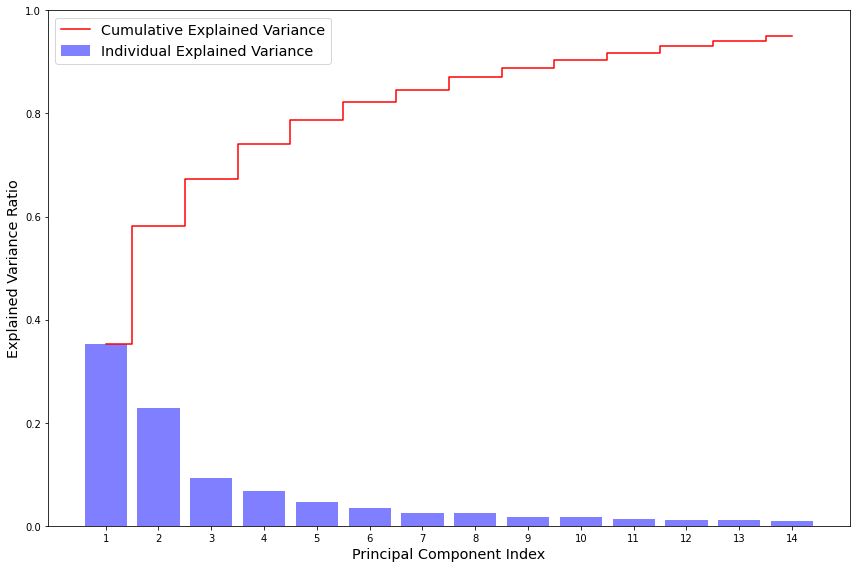

In [96]:
# Create the visualization plot
fontsize = 'x-large'
plt.figure(figsize=(12, 8))
plt.xticks(range(1, len(exp_var_pca)+1, 1))
plt.yticks(np.linspace(0,1,6))
plt.ylim(0,1)
plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center', color='blue', label='Individual Explained Variance')
plt.step(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid', color='red', label='Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio', fontsize=fontsize)
plt.xlabel('Principal Component Index', fontsize=fontsize)
plt.legend(loc='best', fontsize=fontsize)
plt.tight_layout()
plt.show()

In [36]:
cumulative_explained_variances = {}

for n_components in range (1, 21):
    pca = PCA(n_components=n_components)
    pca.fit(train_data_pca_x)
    X_train_pca = pca.fit_transform(X_train_std)
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.sum(explained_variance)
    cumulative_explained_variances[n_components] = cumulative_explained_variance

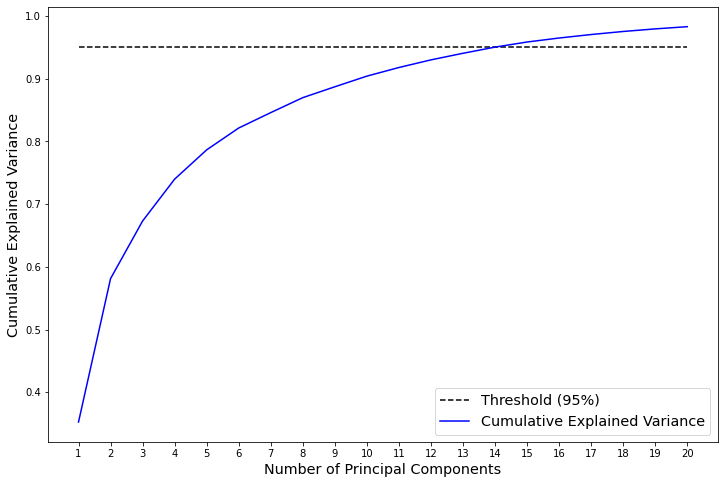

In [100]:
x = list(cumulative_explained_variances.keys())
y = list(cumulative_explained_variances.values())

fontsize = 'x-large'
plt.figure(figsize=(12, 8))
plt.xlabel('Number of Principal Components', fontsize=fontsize)
plt.ylabel('Cumulative Explained Variance', fontsize=fontsize)
plt.xticks(x)
#plt.ylim(0,1)
#plt.axhline(y=0.95, color='black', linestyle='dashed', label='Threshold (95%)')
plt.plot(x, [0.95]*len(x), color='black', linestyle='dashed', label='Threshold (95%)')
plt.plot(x, y, color='blue', label='Cumulative Explained Variance')
plt.legend(loc='lower right', fontsize=fontsize)
plt.show()

In [203]:
import os
import sys
import torch
import numpy as np
from src.custom_types import Behavior, MTDTechnique
from tabulate import tabulate

def split_data(data, split=0.8):
    row = int(len(data) * split)
    X_train = data[:row, :-1].astype(np.float32)
    X_valid = data[row:, :-1].astype(np.float32)
    return X_train, X_valid
    
training_data, test_data, _ = DataProvider.get_scaled_train_test_split(pi=PI, scaling_minmax=True,
                                                                         scale_normal_only=True)
normal_data = training_data[b]
threshold = int(len(normal_data) * 0.5)

training_data[b] = normal_data[:threshold]

ae_training_data = normal_data[threshold:]  # use remaining samples for autoencoder
ae_training_x, ae_valid_x = split_data(ae_training_data)

flattend_test_data = np.empty([0,47])
for behavior, behavior_data in test_data.items():
    if behavior == Behavior.NORMAL:
        n_samples = 2800
        behavior_data[:, -1] =  0
    else:
        n_samples = 400
        behavior_data[:, -1] = 1
    #y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * n_samples)
    
    flattend_test_data = np.concatenate((flattend_test_data, behavior_data[:n_samples]), axis=0)

ae_test_x = flattend_test_data[:,:-1]
ae_test_y = flattend_test_data[:,-1].astype(int)

evaluation_data = {}
for behavior, behavior_data in training_data.items():
    if behavior == Behavior.NORMAL:
        evaluation_data[behavior] = behavior_data[:2800]
    else:
        evaluation_data[behavior] = behavior_data[:400]

In [218]:
from torch import nn
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score

def initial_autoencoder_architecture():
    return nn.Sequential(
        nn.Linear(46, 23),
        nn.BatchNorm1d(23),
        nn.GELU(),
        nn.Linear(23, 11),
        nn.GELU(),
        nn.Linear(11, 23),
        nn.BatchNorm1d(23),
        nn.GELU(),
        nn.Linear(23, 46),
        nn.GELU()
    )

class AutoEncoder(torch.nn.Module):
    

    def __init__(self, model, X_valid, X_test, y_test, evaluation_data, num_stds=[1], activation_function=torch.nn.ReLU(), batch_size: int = 64, verbose=False):

        super().__init__()
        
        validation_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_valid).type(torch.float),

        )
        self.validation_data_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=True, drop_last=True)

        self.X_test = X_test
        self.y_test = y_test
        
        self.evaluation_data = evaluation_data
        self.num_stds = num_stds
        
        n_features = X_test.shape[1]
        
        self.model = model
        self.threshold = None
        self.loss_mean = None
        self.loss_standard_deviation = None
        
        self.verbose = verbose

        
    def forward(self, X):
        return self.model(X)
    
    
    def pretrain(self, X_train, optimizer=torch.optim.SGD, loss_function=torch.nn.MSELoss(reduction='sum'), num_epochs: int = 15, batch_size=64, verbose=False):
        
        training_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_train).type(torch.float),
        )
        training_data_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        epoch_losses = []
        #for e in tqdm(range(num_epochs), unit="epoch", leave=False):
        for e in range(num_epochs):
            self.train()
            current_losses = []
            for batch_index, (inputs,) in enumerate(training_data_loader):
                optimizer.zero_grad()
                outputs = self.forward(inputs)
                loss = loss_function(inputs, outputs)
                loss.backward()
                optimizer.step()
                current_losses.append(loss.item())
            
            epoch_losses.append(np.average(current_losses))
            if verbose:
                print(f'Training Loss in epoch {e + 1}: {epoch_losses[e]}')
            
        self.analyze_loss()

    '''
    This function uses normal data samles 
    after training the autoencoder to determine
    values that can be considered normal
    for the reconstruction loss based on normal samples
    '''
    def analyze_loss(self):
        losses = []
        
        self.eval() 
        with torch.no_grad():
            loss_function = torch.nn.MSELoss(reduction='sum')
            for batch_index, (inputs,) in enumerate(self.validation_data_loader):
                outputs = self.forward(inputs)
                loss = loss_function(inputs, outputs)
                losses.append(loss.item())
        
        losses = np.array(losses)

        self.loss_mean = losses.mean()
        self.loss_standard_deviation = losses.std()

        
    def predict(self, x, num_std = 1):
        test_data = torch.utils.data.TensorDataset(
            torch.from_numpy(x).type(torch.float32)
        )
        test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

        all_predictions = torch.tensor([])  # .cuda()

        self.eval()
        with torch.no_grad():
            ae_loss = torch.nn.MSELoss(reduction="sum")
            for idx, (batch_x,) in enumerate(test_data_loader):
                model_predictions = self.forward(batch_x)
                model_predictions = ae_loss(model_predictions, batch_x).unsqueeze(0)  # unsqueeze as batch_size set to 1
                all_predictions = torch.cat((all_predictions, model_predictions))

        threshold = self.loss_mean + num_std * self.loss_standard_deviation
        all_predictions = (all_predictions > threshold).type(torch.long)
        return all_predictions.flatten()
    
    
    def predict_deviation(self, x):
        test_data = torch.utils.data.TensorDataset(
            torch.from_numpy(x).type(torch.float32)
        )
        test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

        prediction_errors = torch.tensor([])
        loss_function = torch.nn.MSELoss(reduction="sum")
        
        self.eval()
        with torch.no_grad():
            
            for batch_index, (inputs,) in enumerate(test_data_loader):
                prediction = self.forward(inputs)
                prediction_error = loss_function(inputs, prediction).unsqueeze(0)  # unsqueeze as batch_size set to 1
                prediction_errors = torch.cat((prediction_errors, prediction_error))

        return prediction_errors
    
    
    def score(self):
        num_std, accuracy = self.accuracy_score(None, None)
        if self.verbose:
            print(f"Highest validation accuracy achieved {accuracy:.2f} with num_std={num_std}")
            self.evaluate(num_std)
        return accuracy
    
    
    def accuracy_score(self, X, y):
        #if not self.threshold:
        #loss_mean, loss_standard_deviation = self.analyze_loss(X)
        #num_stds = np.arange(0.1, 3, 0.1)
        if self.loss_mean == None or self.loss_standard_deviation == None:
              #print("accuracy_score_optimized > accurcy_loss()")
              self.analyze_loss()
    
        best_accuracy = 0
        best_num_std = 0
        #accuracies = []
        y_dev = self.predict_deviation((self.X_test).astype(np.float32))
        for num_std in self.num_stds:
            y_true = self.y_test
            threshold = self.loss_mean + num_std * self.loss_standard_deviation
            y_pred = (y_dev > threshold).type(torch.long).detach().cpu().numpy()
            
            accuracy = accuracy_score(y_true, y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_std = num_std
            #if self.verbose:
            #    print(f"num_std {num_std:.2f} -> accuracy: {accuracy}")

        return best_num_std, best_accuracy
    
    
    def evaluate(self, num_std=0.1, tablefmt='pipe'):
        results = []
        labels= [0,1]
        pos_label = 1
        
        y_true_total = np.empty([0])
        y_pred_total = np.empty([0])
        for behavior, data in self.evaluation_data.items():
            y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * len(data)).astype(int)
            y_true_total = np.concatenate((y_true_total, y_true))

            y_pred = self.predict(data[:, :-1].astype(np.float32), num_std=num_std)
            y_pred_total = np.concatenate((y_pred_total, y_pred))

            accuracy = accuracy_score(y_true, y_pred)

            n_samples = len(y_true)
            results.append([behavior.name.replace("_", "\_"), f'{(100 * accuracy):.2f}\%', '\\notCalculated', '\\notCalculated', '\\notCalculated', str(n_samples)])

        accuracy = accuracy_score(y_true_total, y_pred_total)
        precision = precision_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        recall = recall_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        f1 = f1_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        n_samples = len(y_true_total)
        results.append(["GLOBAL", f'{(100 * accuracy):.2f}\%', f'{(100 * precision):.2f}\%', f'{(100 * recall):.2f}\%', f'{(100 * f1):.2f}\%', n_samples])
        print("-----------")
        print(tabulate(results, headers=["Behavior", "Accuracy", "Precision", "Recall", "F1-Score", "\#Samples"], tablefmt=tablefmt)) 

### 4.2 Autoencoder > Initial Architecture Evaluation

In [254]:
initial_autoencoder = AutoEncoder(initial_autoencoder_architecture(), ae_valid_x, ae_test_x, ae_test_y, evaluation_data)
initial_autoencoder.pretrain(ae_training_x, optimizer=torch.optim.SGD(autoencoder.parameters(), lr=1e-4, momentum=0.9), num_epochs=100, batch_size=64, verbose=False)
initial_autoencoder.evaluate(num_std=2.5, tablefmt='latex_raw')

-----------
\begin{tabular}{llllll}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       & #Samples   \\
\hline
 NORMAL                   & 86.39\%    & \notCalculated & \notCalculated & \notCalculated & \2800      \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated & \400       \\
 ROOTKIT\_BDVL            & 95.75\%    & \notCalculated & \notCalculated & \notCalculated & \400       \\
 ROOTKIT\_BEURK           & 17.25\%    & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_THETICK             & 10.00\%    & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_BACKDOOR\_JAKORITAR & 6.50\%     & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_OPT1                & 44.00\%    & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated & \400      

### 4.3 Autoencoder > Hyperparameter Search

In [214]:
import skorch
from skorch import NeuralNet, NeuralNetRegressor
from skorch.scoring import loss_scoring

class StateAnomalyDetector(skorch.NeuralNet):
    def score(self, X, y=None):
        return self.module_.score()
    
    def evaluate(self):
        self.module_.evaluate()

In [215]:
from skorch import NeuralNet, NeuralNetRegressor
from skorch.callbacks import LRScheduler, EarlyStopping

state_anomaly_detector = StateAnomalyDetector(
    module=AutoEncoder,
    
    criterion=torch.nn.MSELoss(reduction='mean'),
    optimizer=torch.optim.SGD,
    optimizer__lr=0.0001,
    optimizer__weight_decay=0.01,
    
    iterator_train__shuffle=True,
    max_epochs=20,
    batch_size=32,
    
    module__model=initial_autoencoder_architecture(),
    module__X_valid=ae_valid_x,
    module__X_test=ae_test_x,
    module__y_test=ae_test_y,
    module__evaluation_data=evaluation_data,
    module__activation_function=nn.GELU(),
    module__num_stds=np.linspace(0.1, 3, 30),
    module__verbose=True,
    
    verbose=True,
    
    callbacks=[EarlyStopping(patience=5, monitor='valid_loss')]

)

In [148]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [220]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'verbose': [False],
    'criterion': [RMSELoss, torch.nn.L1Loss, torch.nn.MSELoss],
    'optimizer': [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop],
    'lr': [0.0001, 0.00001],
    'max_epochs': [20],
    'batch_size': [64],
    #'module__activation_function': [torch.nn.Tanh(), torch.nn.GELU(), torch.nn.ReLU(), torch.nn.Sigmoid(), torch.nn.ELU()],
    'module__activation_function': [torch.nn.GELU()],
}

ae_grid_search_01 = GridSearchCV(estimator=state_anomaly_detector,
                                 param_grid=param_grid,
                                 n_jobs=1,
                                 cv=3,
                                 verbose=10,
                                 refit=False,
                                )
ae_grid_search_01_result = ae_grid_search_01.fit(ae_training_x, ae_training_x)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3; 1/18] START batch_size=64, criterion=<class '__main__.RMSELoss'>, lr=0.0001, max_epochs=20, module__activation_function=GELU(approximate='none'), optimizer=<class 'torch.optim.adam.Adam'>, verbose=False
Highest validation accuracy achieved 0.70 with num_std=2.8
-----------
| Behavior                 | Accuracy   | Precision      | Recall         | F1-Score       | #Samples   |
|:-------------------------|:-----------|:---------------|:---------------|:---------------|:-----------|
| NORMAL                   | 97.89\%    | \notCalculated | \notCalculated | \notCalculated | \2800      |
| RANSOMWARE\_POC          | 100.00\%   | \notCalculated | \notCalculated | \notCalculated | \400       |
| ROOTKIT\_BDVL            | 99.50\%    | \notCalculated | \notCalculated | \notCalculated | \400       |
| ROOTKIT\_BEURK           | 3.25\%     | \notCalculated | \notCalculated | \notCalculated | \400       |
| CNC\_THETICK      

In [221]:
ae_grid_search_01_result_table = convert_grid_search_result(ae_grid_search_01_result)
display_grid_search_result(ae_grid_search_01_result_table)

\begin{tabular}{lrrlrrlll}
\toprule
{} &  mean\_validation\_accuracy &  batch\_size &                                criterion &       lr &  max\_epochs & module\_\_activation\_function &                              optimizer &  verbose \\
\midrule
\textbf{1 } &                  0.710714 &          64 &  <class 'torch.nn.modules.loss.MSELoss'> &  0.00010 &          20 &    GELU(approximate='none') &          <class 'torch.optim.sgd.SGD'> &    False \\
\textbf{2 } &                  0.710238 &          64 &  <class 'torch.nn.modules.loss.MSELoss'> &  0.00001 &          20 &    GELU(approximate='none') &          <class 'torch.optim.sgd.SGD'> &    False \\
\textbf{3 } &                  0.710238 &          64 &   <class 'torch.nn.modules.loss.L1Loss'> &  0.00010 &          20 &    GELU(approximate='none') &          <class 'torch.optim.sgd.SGD'> &    False \\
\textbf{4 } &                  0.710119 &          64 &              <class '\_\_main\_\_.RMSELoss'> &  0.00001 &          20 &  

In [240]:
ae_grid_search_01_result_table.head(10)

,mean_validation_accuracy,batch_size,criterion,lr,max_epochs,module__activation_function,optimizer,verbose
1,0.710714,64,<class 'torch.nn.modules.loss.MSELoss'>,0.00010,20,GELU(approximate='none'),<class 'torch.optim.sgd.SGD'>,False
2,0.710238,64,<class 'torch.nn.modules.loss.MSELoss'>,0.00001,20,GELU(approximate='none'),<class 'torch.optim.sgd.SGD'>,False
3,0.710238,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00010,20,GELU(approximate='none'),<class 'torch.optim.sgd.SGD'>,False
4,0.710119,64,<class '__main__.RMSELoss'>,0.00001,20,GELU(approximate='none'),<class 'torch.optim.sgd.SGD'>,False
5,0.709940,64,<class '__main__.RMSELoss'>,0.00010,20,GELU(approximate='none'),<class 'torch.optim.sgd.SGD'>,False
6,0.709821,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00001,20,GELU(approximate='none'),<class 'torch.optim.sgd.SGD'>,False
7,0.707976,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00010,20,GELU(approximate='none'),<class 'torch.optim.rmsprop.RMSprop'>,False
8,0.707024,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00001,20,GELU(approximate='none'),<class 'torch.optim.adam.Adam'>,False
9,0.706964,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00010,20,GELU(approximate='none'),<class 'torch.optim.adam.Adam'>,False
10,0.705833,64,<class 'torch.nn.modules.loss.MSELoss'>,0.00001,20,GELU(approximate='none'),<class 'torch.optim.adam.Adam'>,False


In [244]:
autoencoder = AutoEncoder(initial_autoencoder_architecture(), ae_valid_x, ae_test_x, ae_test_y, evaluation_data)
autoencoder.pretrain(ae_training_x, optimizer=torch.optim.Adam(autoencoder.parameters(), lr=1e-4,  weight_decay=0.01), loss_function=RMSELoss(), num_epochs=100, batch_size=64, verbose=True)
autoencoder.evaluate(num_std=2.5, tablefmt='latex_raw')

Training Loss in epoch 1: 0.38266986757516863
Training Loss in epoch 2: 0.3630200415849686
Training Loss in epoch 3: 0.343880536655585
Training Loss in epoch 4: 0.32566845367352165
Training Loss in epoch 5: 0.3085550680756569
Training Loss in epoch 6: 0.2925955613454183
Training Loss in epoch 7: 0.27672968556483585
Training Loss in epoch 8: 0.2608952489991983
Training Loss in epoch 9: 0.24446614558498064
Training Loss in epoch 10: 0.2290728601316611
Training Loss in epoch 11: 0.2139025780061881
Training Loss in epoch 12: 0.1999205191930135
Training Loss in epoch 13: 0.18690573771794636
Training Loss in epoch 14: 0.17554601008693377
Training Loss in epoch 15: 0.16502170488238335
Training Loss in epoch 16: 0.15687555919090906
Training Loss in epoch 17: 0.14754326517383257
Training Loss in epoch 18: 0.1409994116673867
Training Loss in epoch 19: 0.13529607765376567
Training Loss in epoch 20: 0.12887703118224939
Training Loss in epoch 21: 0.12534602309266726
Training Loss in epoch 22: 0.121

### 4.4 Tied Autoencoder > Hyperparameter Search

In [230]:
import numpy as np
import torch.nn.functional as F

from torch import nn

class TiedAutoEncoder(AutoEncoder):
    

    def __init__(self, X_valid, X_test, y_test, evaluation_data, num_stds=[1], activation_function=torch.nn.ReLU(), batch_size: int = 64, verbose=False):
        
        super(TiedAutoEncoder, self).__init__(None, X_valid, X_test, y_test, evaluation_data)

        n_features = X_valid.shape[1]
        self.weight_matrix_1 = nn.Parameter(torch.randn(n_features, 30))
        self.weight_matrix_2 = nn.Parameter(torch.randn(30, 20))
        self.weight_matrix_3 = nn.Parameter(torch.randn(20, 10))
        
        
    def forward(self, x):
        x = F.relu(F.linear(x, self.weight_matrix_1.T))
        x = F.relu(F.linear(x, self.weight_matrix_2.T))
        x = F.relu(F.linear(x, self.weight_matrix_3.T))
        x = F.relu(F.linear(x, self.weight_matrix_3))
        x = F.relu(F.linear(x, self.weight_matrix_2))
        x = F.relu(F.linear(x, self.weight_matrix_1))
        return x

In [231]:
tied_state_anomaly_detector = StateAnomalyDetector(
    module=TiedAutoEncoder,
    
    criterion=torch.nn.MSELoss(reduction='mean'),
    optimizer=torch.optim.SGD,
    optimizer__lr=0.0001,
    optimizer__weight_decay=0.01,
    
    iterator_train__shuffle=True,
    max_epochs=20,
    batch_size=32,
    
    module__X_valid=ae_valid_x,
    module__X_test=ae_test_x,
    module__y_test=ae_test_y,
    module__evaluation_data=evaluation_data,
    module__activation_function=nn.GELU(),
    module__num_stds=np.linspace(0.1, 3, 30),
    module__verbose=True,
    
    verbose=False,
    
    callbacks=[EarlyStopping(patience=5, monitor='valid_loss')]
)

In [233]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'verbose': [False],
    'criterion': [RMSELoss, torch.nn.L1Loss, torch.nn.MSELoss],
    'optimizer': [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop],
    'lr': [0.0000001, 0.00000001],
    'max_epochs': [20],
    'batch_size': [64],
    #'module__activation_function': [torch.nn.Tanh(), torch.nn.GELU(), torch.nn.ReLU(), torch.nn.Sigmoid(), torch.nn.ELU()],
    'module__activation_function': [torch.nn.GELU()],
}

ae_grid_search_02 = GridSearchCV(estimator=tied_state_anomaly_detector,
                                 param_grid=param_grid,
                                 n_jobs=1,
                                 cv=3,
                                 verbose=3,
                                 refit=False,
                                 return_train_score=True,
                                )
ae_grid_search_02_result = ae_grid_search_02.fit(ae_training_x, ae_training_x)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END batch_size=64, criterion=<class '__main__.RMSELoss'>, lr=1e-07, max_epochs=20, module__activation_function=GELU(approximate='none'), optimizer=<class 'torch.optim.adam.Adam'>, verbose=False;, score=(train=0.677, test=0.677) total time=   1.8s
[CV 2/3] END batch_size=64, criterion=<class '__main__.RMSELoss'>, lr=1e-07, max_epochs=20, module__activation_function=GELU(approximate='none'), optimizer=<class 'torch.optim.adam.Adam'>, verbose=False;, score=(train=0.679, test=0.679) total time=   2.2s
[CV 3/3] END batch_size=64, criterion=<class '__main__.RMSELoss'>, lr=1e-07, max_epochs=20, module__activation_function=GELU(approximate='none'), optimizer=<class 'torch.optim.adam.Adam'>, verbose=False;, score=(train=0.688, test=0.688) total time=   1.6s
[CV 1/3] END batch_size=64, criterion=<class '__main__.RMSELoss'>, lr=1e-07, max_epochs=20, module__activation_function=GELU(approximate='none'), optimizer=<class 'torch.o

In [168]:
ae_grid_search_02_result_table = convert_grid_search_result(ae_grid_search_02_result)
display_grid_search_result(ae_grid_search_02_result_table)

\begin{tabular}{lrrlrrlllrl}
\toprule
{} &  mean\_validation\_accuracy &  batch\_size &                                criterion &       lr &  max\_epochs & module\_\_activation\_function &  module\_\_verbose &                              optimizer &  optimizer\_\_weight\_decay &  verbose \\
\midrule
\textbf{1 } &                  0.711310 &          64 &   <class 'torch.nn.modules.loss.L1Loss'> &  0.00001 &          20 &    GELU(approximate='none') &             True &        <class 'torch.optim.adam.Adam'> &                     0.01 &    False \\
\textbf{2 } &                  0.703393 &          64 &   <class 'torch.nn.modules.loss.L1Loss'> &  0.00010 &          20 &    GELU(approximate='none') &             True &        <class 'torch.optim.adam.Adam'> &                     0.01 &    False \\
\textbf{3 } &                  0.700893 &          64 &   <class 'torch.nn.modules.loss.L1Loss'> &  0.00001 &          20 &    GELU(approximate='none') &             True &  <class 'torch.opt

In [234]:
ae_grid_search_02_result_table.head(10)

,mean_validation_accuracy,batch_size,criterion,lr,max_epochs,module__activation_function,module__verbose,optimizer,optimizer__weight_decay,verbose
1,0.711310,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00001,20,GELU(approximate='none'),True,<class 'torch.optim.adam.Adam'>,0.01,False
2,0.703393,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00010,20,GELU(approximate='none'),True,<class 'torch.optim.adam.Adam'>,0.01,False
3,0.700893,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00001,20,GELU(approximate='none'),True,<class 'torch.optim.rmsprop.RMSprop'>,0.01,False
4,0.700119,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00001,20,GELU(approximate='none'),True,<class 'torch.optim.sgd.SGD'>,0.01,False
5,0.697738,64,<class '__main__.RMSELoss'>,0.00010,20,GELU(approximate='none'),True,<class 'torch.optim.adam.Adam'>,0.01,False
6,0.697500,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00010,20,GELU(approximate='none'),True,<class 'torch.optim.rmsprop.RMSprop'>,0.01,False
7,0.695476,64,<class '__main__.RMSELoss'>,0.00001,20,GELU(approximate='none'),True,<class 'torch.optim.rmsprop.RMSprop'>,0.01,False
8,0.691429,64,<class 'torch.nn.modules.loss.MSELoss'>,0.00010,20,GELU(approximate='none'),True,<class 'torch.optim.rmsprop.RMSprop'>,0.01,False
9,0.689762,64,<class '__main__.RMSELoss'>,0.00010,20,GELU(approximate='none'),True,<class 'torch.optim.rmsprop.RMSprop'>,0.01,False
10,0.689345,64,<class 'torch.nn.modules.loss.MSELoss'>,0.00001,20,GELU(approximate='none'),True,<class 'torch.optim.rmsprop.RMSprop'>,0.01,False


In [245]:
tied_autoencoder = TiedAutoEncoder(ae_valid_x, ae_test_x, ae_test_y, evaluation_data, num_stds=[2.5], activation_function=torch.nn.GELU(), batch_size=64)
tied_autoencoder.pretrain(ae_training_x, optimizer=torch.optim.Adam(tied_autoencoder.parameters(), lr=0.00001) ,loss_function=torch.nn.L1Loss(), num_epochs=100, batch_size=64, verbose=True)
tied_autoencoder.evaluate(num_std=2.5, tablefmt='latex_raw')

Training Loss in epoch 1: 435.89940134684247
Training Loss in epoch 2: 430.4549560546875
Training Loss in epoch 3: 424.53600921630857
Training Loss in epoch 4: 418.6495519002279
Training Loss in epoch 5: 413.1371587117513
Training Loss in epoch 6: 407.61169484456383
Training Loss in epoch 7: 402.2019948323568
Training Loss in epoch 8: 396.82637176513674
Training Loss in epoch 9: 391.7884450276693
Training Loss in epoch 10: 386.6036010742188
Training Loss in epoch 11: 381.40386962890625
Training Loss in epoch 12: 376.47752075195314
Training Loss in epoch 13: 371.2980422973633
Training Loss in epoch 14: 366.6408126831055
Training Loss in epoch 15: 361.86222483317056
Training Loss in epoch 16: 356.9101760864258
Training Loss in epoch 17: 352.3812611897786
Training Loss in epoch 18: 347.8084070841471
Training Loss in epoch 19: 343.08237609863284
Training Loss in epoch 20: 338.74907836914065
Training Loss in epoch 21: 334.3351486206055
Training Loss in epoch 22: 329.77307586669923
Training 